<a href="https://colab.research.google.com/github/jstovold/ALIFE2023/blob/master/InternalSignals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Growing Multiple Organisms in the Same Neural Cellular Automata (internal signals)
### James Stovold
### Nov 2022

<!-- > Indented block -->

Code to support ALIFE 2023 paper: 
 > J. Stovold, "Neural Cellular Automata can Respond to Signals"

Along with: [ExternalSignals.ipynb](https://github.com/jstovold/ALIFE2023/blob/master/ExternalSignals.ipynb)

Genome: `[left_arm, right_arm, left_leg, right_leg]` (all binary)


Based on the Colab notebook developed by Mordvintsev et al. for the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

Code and materials are restricted for any and all use prior to publication; post-publication the code and associated materials are available under the Apache 2.0 license

<!-- Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License. -->

In [1]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import random
import datetime

from scipy.ndimage.interpolation import rotate as scipy_rotate


import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def rotate(img, angle=90):
  img = scipy_rotate(img, angle=angle)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [2]:
#@title Cellular Automata Parameters

PARAM_N  = 6                   # Number of genes in the genome
JUNK_DNA = 10                   # Number of "empty" spaces in the genome for the CA to communicate between cells
CHANNEL_N = 4 + PARAM_N + JUNK_DNA  # Total number of CA state channels (+ 4 for RGBA)
TARGET_PADDING = 15             # Number of pixels used to pad the target image border
TARGET_SIZE = 30
TARGET_PADDED_SIZE = TARGET_SIZE + TARGET_PADDING * 2

BATCH_SIZE = 12
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


In [3]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D


def load_image(url, max_size=TARGET_SIZE, zoom=1):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size*zoom, max_size*zoom), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  img[...,:3] *= img[..., 3:]
  return img


def load_parts(arms="lr", legs="lr", headtail="ht", zoom=1):
  url = "https://github.com/jstovold/ALIFE2023/blob/master/gecko_legs/gecko_" + headtail + "_" + arms + "_" + legs + ".png?raw=true"
  return load_image(url, zoom=zoom)

# head, left_arm, right_arm, left_leg, right_leg, tail
def load_parts_genome(genome=(0,0,0,0)):
  return load_parts_ind(
       left_arm  = genome[0]
      ,right_arm = genome[1]
      ,left_leg  = genome[2]
      ,right_leg = genome[3]
      )

def load_parts_ind(left_arm=0, right_arm=0, left_leg=0, right_leg=0):
  arms=""
  legs=""
  headtail=""

  if left_arm==1:
    arms+="l"
  if right_arm==1:
    arms+="r"
  
  if left_leg==1:
    legs+="l"
  if right_leg==1:
    legs+="r"
  
  if arms=="":
    arms="0"
  if legs=="":
    legs="0"
  
  
  headtail+="h"
  headtail+="t"

  if headtail=="":
    headtail="0"

  return load_parts(arms=arms, legs=legs, headtail=headtail)

def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb


def get_channels(x, ch=[5,6,7]):
  rgb, a = x[..., ch], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x, threshold = 0.1):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > threshold

def get_living(x):
  alpha = x[0, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1



class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu, name='layer1'),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer, name='layer2'),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)
    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)
    
    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (1, 3, 3, 128)            7808      
                                                                 
 layer2 (Conv2D)             (1, 3, 3, 20)             2580      
                                                                 
Total params: 10,388
Trainable params: 10,388
Non-trainable params: 0
_________________________________________________________________


# Training

In [4]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)




@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, y0, step_i): 
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis2 = np.hstack(to_rgb(y0).numpy())
  vis = np.vstack([vis0, vis1, vis2])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(zoom(vis,2))

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


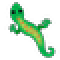

In [5]:
#@title Choose Target Image { vertical-output: true}

target_img = load_parts_genome((1,0,0,1))
imshow(zoom(to_rgba(target_img), 2), fmt='png')




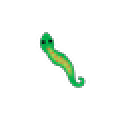

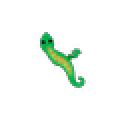

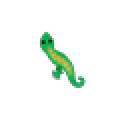

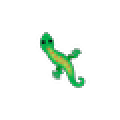

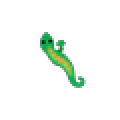

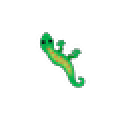

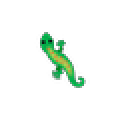

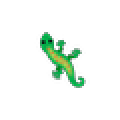

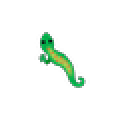

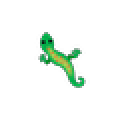

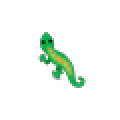

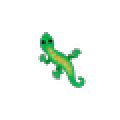

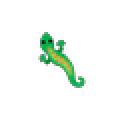

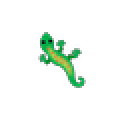

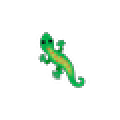

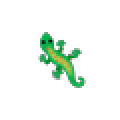

In [6]:
#@title Pull the target images from github according to genome { vertical-output: true }

# bit of a brute-force approach, definitely a more 
# elegant way to do this...

target_img_1 = load_parts_genome((0,0,0,0))
target_img_2 = load_parts_genome((0,0,0,1))

target_img_3 = load_parts_genome((0,0,1,0))
target_img_4 = load_parts_genome((0,0,1,1))

target_img_5 = load_parts_genome((0,1,0,0))
target_img_6 = load_parts_genome((0,1,0,1))

target_img_7 = load_parts_genome((0,1,1,0))
target_img_8 = load_parts_genome((0,1,1,1))


target_img_9  = load_parts_genome((1,0,0,0))
target_img_10 = load_parts_genome((1,0,0,1))

target_img_11 = load_parts_genome((1,0,1,0))
target_img_12 = load_parts_genome((1,0,1,1))

target_img_13 = load_parts_genome((1,1,0,0))
target_img_14 = load_parts_genome((1,1,0,1))

target_img_15 = load_parts_genome((1,1,1,0))
target_img_16 = load_parts_genome((1,1,1,1))

# pad the target images:
h, w = target_img_1.shape[:2]
p = (TARGET_PADDED_SIZE - h) // 2
padded_img_1 = tf.pad(target_img_1, [[p, p], [p,p], [0,0]])
padded_img_2 = tf.pad(target_img_2, [[p, p], [p,p], [0,0]])
padded_img_3 = tf.pad(target_img_3, [[p, p], [p,p], [0,0]])
padded_img_4 = tf.pad(target_img_4, [[p, p], [p,p], [0,0]])
padded_img_5 = tf.pad(target_img_5, [[p, p], [p,p], [0,0]])
padded_img_6 = tf.pad(target_img_6, [[p, p], [p,p], [0,0]])
padded_img_7 = tf.pad(target_img_7, [[p, p], [p,p], [0,0]])
padded_img_8 = tf.pad(target_img_8, [[p, p], [p,p], [0,0]])

padded_img_9  = tf.pad(target_img_9,  [[p, p], [p,p], [0,0]])
padded_img_10 = tf.pad(target_img_10, [[p, p], [p,p], [0,0]])
padded_img_11 = tf.pad(target_img_11, [[p, p], [p,p], [0,0]])
padded_img_12 = tf.pad(target_img_12, [[p, p], [p,p], [0,0]])
padded_img_13 = tf.pad(target_img_13, [[p, p], [p,p], [0,0]])
padded_img_14 = tf.pad(target_img_14, [[p, p], [p,p], [0,0]])
padded_img_15 = tf.pad(target_img_15, [[p, p], [p,p], [0,0]])
padded_img_16 = tf.pad(target_img_16, [[p, p], [p,p], [0,0]])

# display them all...
imshow(zoom(to_rgba(padded_img_1),2),fmt='png')
imshow(zoom(to_rgba(padded_img_2),2),fmt='png')
imshow(zoom(to_rgba(padded_img_3),2),fmt='png')
imshow(zoom(to_rgba(padded_img_4),2),fmt='png')
imshow(zoom(to_rgba(padded_img_5),2),fmt='png')
imshow(zoom(to_rgba(padded_img_6),2),fmt='png')
imshow(zoom(to_rgba(padded_img_7),2),fmt='png')
imshow(zoom(to_rgba(padded_img_8),2),fmt='png')

imshow(zoom(to_rgba(padded_img_9),2),fmt='png')
imshow(zoom(to_rgba(padded_img_10),2),fmt='png')
imshow(zoom(to_rgba(padded_img_11),2),fmt='png')
imshow(zoom(to_rgba(padded_img_12),2),fmt='png')
imshow(zoom(to_rgba(padded_img_13),2),fmt='png')
imshow(zoom(to_rgba(padded_img_14),2),fmt='png')
imshow(zoom(to_rgba(padded_img_15),2),fmt='png')
imshow(zoom(to_rgba(padded_img_16),2),fmt='png')




In [7]:
#@title Initialize Training { vertical-output: true}

genome = (0,0,0,1)

h, w = padded_img_1.shape[:2]
print(h,w)
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:]  = 1.0
seed[h//2, w//2, 0:3] = (0,0,0)
seed[h//2, w//2, 4:8] = genome

def loss_f(x, y):
  return tf.reduce_mean(tf.square(to_rgba(x)-to_rgba(y)), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000, 4000, 6000, 10000], [lr, lr*0.5, lr * 0.1, lr * 0.05, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)


loss0 = loss_f(seed, padded_img_2).numpy() 

pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0),
                  y=np.repeat(padded_img_2[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

60 60


batch (before/after):


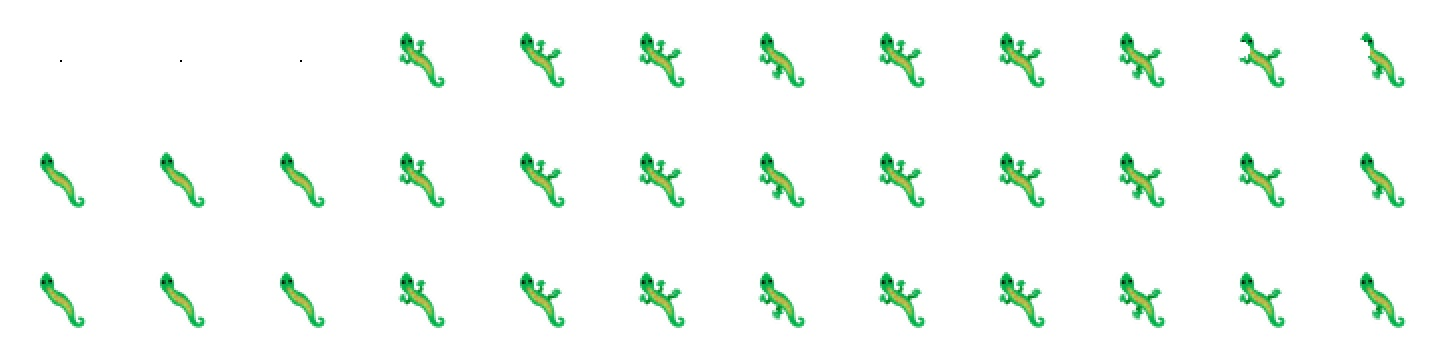

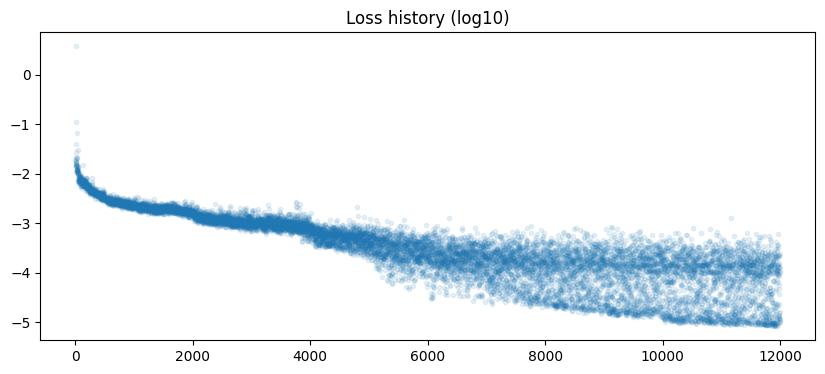

 step: 12001, log10(loss): -4.994
 1:08:14.008164


In [8]:
#@title Training Loop {vertical-output: true}


@tf.function
def train_step(x, y):
  iter_n = tf.random.uniform([], 64, 200, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, y))# shape, colour))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

@tf.function
def make_seed_genome(genome=(0,0,0,0)):
  h, w = (TARGET_PADDED_SIZE, TARGET_PADDED_SIZE)
  seed = np.zeros([h, w, CHANNEL_N], np.float32)
  seed[h//2, w//2, 3:] = 1.0
  seed[h//2, w//2, 0:3] = (0,0,0)
  seed[h//2, w//2, 4:8] = genome
  return seed





@tf.function
def get_target_genome(genome):
  # again, not very elegant, but it'll work...
  if   genome == (0,0,0,0):
    target_img_scale = target_img_1
  elif genome == (0,0,0,1):
    target_img_scale = target_img_2
  elif genome == (0,0,1,0):
    target_img_scale = target_img_3
  elif genome == (0,0,1,1):
    target_img_scale = target_img_4
  elif genome == (0,1,0,0):
    target_img_scale = target_img_5
  elif genome == (0,1,0,1):
    target_img_scale = target_img_6
  elif genome == (0,1,1,0):
    target_img_scale = target_img_7
  elif genome == (0,1,1,1):
    target_img_scale = target_img_8

  elif genome == (1,0,0,0):
    target_img_scale = target_img_9
  elif genome == (1,0,0,1):
    target_img_scale = target_img_10
  elif genome == (1,0,1,0):
    target_img_scale = target_img_11
  elif genome == (1,0,1,1):
    target_img_scale = target_img_12
  elif genome == (1,1,0,0):
    target_img_scale = target_img_13
  elif genome == (1,1,0,1):
    target_img_scale = target_img_14
  elif genome == (1,1,1,0):
    target_img_scale = target_img_15
  elif genome == (1,1,1,1):
    target_img_scale = target_img_16
  else:
    target_img_scale = 0 # e.g. something has gone wrong

  img_w = target_img_scale.shape[:1][0]
  p = (TARGET_PADDED_SIZE - img_w) // 2
  pad_target_temp = tf.pad(to_rgba(target_img_scale), [[p, p], [p,p], [0,0]])
  return(pad_target_temp)
    

tic = datetime.datetime.now()
switch = 0
genome = (0,0,0,1)
switch_step = 3

for i in range(12000+1):
  if i % switch_step == 0:  
    # a much nicer approach would be to convert `switch' to its binary 
    # representation, keep in mind for next time...

    if switch == 0: 
      genome = (0,0,0,0)
      switch += 1
    elif switch == 1:
      genome = (0,0,0,1)
      switch += 1
    elif switch == 2:   
      genome = (0,0,1,0)
      switch += 1
    elif switch == 3:   
      genome = (0,0,1,1)
      switch += 1
    elif switch == 4:   
      genome = (0,1,0,0)
      switch += 1
    elif switch == 5:   
      genome = (0,1,0,1)
      switch += 1
    elif switch == 6:   
      genome = (0,1,1,0)
      switch += 1
    elif switch == 7:   
      genome = (0,1,1,1)
      switch += 1

    elif switch == 8: 
      genome = (1,0,0,0)
      switch += 1
    elif switch == 9: 
      genome = (1,0,0,1)
      switch += 1
    elif switch == 10:   
      genome = (1,0,1,0)
      switch += 1
    elif switch == 11:   
      genome = (1,0,1,1)
      switch += 1
    elif switch == 12:   
      genome = (1,1,0,0)
      switch += 1
    elif switch == 13:   
      genome = (1,1,0,1)
      switch += 1
    elif switch == 14:   
      genome = (1,1,1,0)
      switch += 1
    elif switch == 15:   
      genome = (1,1,1,1)
      switch = 0

    else: # something has gone wrong...
      genome = (0,0,0,0)
      switch = 0
    
  
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    y0 = batch.y
    loss_rank = loss_f(x0, y0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    y0 = y0[loss_rank]
    x0[:3] = make_seed_genome(genome)
    y0[:3] = get_target_genome(genome)
    if DAMAGE_N:
      damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
      x0[-DAMAGE_N:] *= damage
  else:
    seed = make_seed_genome(genome)
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    

  x, loss = train_step(x0, y0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.y[:] = y0
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
  
  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    
    visualize_batch(x0, x, y0, step_i)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')
toc = datetime.datetime.now()
print("\n", toc - tic)

# Figures

In [9]:
#@title Training Progress (Checkpoints) {vertical-output:false}

def make_many_seeds_genome(num=1, genome=(0,0,0,0)):
  h, w = (TARGET_PADDED_SIZE, TARGET_PADDED_SIZE)
  seed = np.zeros([num, h, w, CHANNEL_N], np.float32)
  seed[..., h//2, w//2, 3:] = 1.0
  seed[..., h//2, w//2, 0:3] = (0,0,0)
  seed[..., h//2, w//2, 4:8] = genome
  return seed


# model_nums = [100, 500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]
model_nums = [12000]
models = []
for i in model_nums:
  ca = CAModel()
  ca.load_weights('train_log/%04d'%i)
  models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%1
# x = make_many_seeds_genome(len(models), (0,0,0,0))

models0 = models.copy()
models1 = models.copy()
models2 = models.copy()
models3 = models.copy()

models4 = models.copy()
models5 = models.copy()
models6 = models.copy()
models7 = models.copy()

models8 = models.copy()
models9 = models.copy()
models10 = models.copy()
models11 = models.copy()

models12 = models.copy()
models13 = models.copy()
models14 = models.copy()
models15 = models.copy()

x0 = make_many_seeds_genome(len(models), (0,0,0,0))
x1 = make_many_seeds_genome(len(models), (0,0,0,1))
x2 = make_many_seeds_genome(len(models), (0,0,1,0))
x3 = make_many_seeds_genome(len(models), (0,0,1,1))

x4 = make_many_seeds_genome(len(models), (0,1,0,0))
x5 = make_many_seeds_genome(len(models), (0,1,0,1))
x6 = make_many_seeds_genome(len(models), (0,1,1,1))
x7 = make_many_seeds_genome(len(models), (0,1,1,1))

x8  = make_many_seeds_genome(len(models), (1,0,0,0))
x9  = make_many_seeds_genome(len(models), (1,0,0,1))
x10 = make_many_seeds_genome(len(models), (1,0,1,0))
x11 = make_many_seeds_genome(len(models), (1,0,1,1))

x12 = make_many_seeds_genome(len(models), (1,1,0,0))
x13 = make_many_seeds_genome(len(models), (1,1,0,1))
x14 = make_many_seeds_genome(len(models), (1,1,1,0))
x15 = make_many_seeds_genome(len(models), (1,1,1,1))


with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):


    vis0 = np.hstack(to_rgb(x0))
    vis1 = np.hstack(to_rgb(x1))
    vis2 = np.hstack(to_rgb(x2))
    vis3 = np.hstack(to_rgb(x3))
    vis4 = np.hstack(to_rgb(x4))
    vis5 = np.hstack(to_rgb(x5))
    vis6 = np.hstack(to_rgb(x6))
    vis7 = np.hstack(to_rgb(x7))

    vis8 = np.hstack(to_rgb(x8))
    vis9 = np.hstack(to_rgb(x9))
    vis10 = np.hstack(to_rgb(x10))
    vis11 = np.hstack(to_rgb(x11))
    vis12 = np.hstack(to_rgb(x12))
    vis13 = np.hstack(to_rgb(x13))
    vis14 = np.hstack(to_rgb(x14))
    vis15 = np.hstack(to_rgb(x15))
  
  
    vis = np.vstack((np.hstack((
                       vis0
                      ,vis1
                      ,vis2
                      ,vis3))
                     ,np.hstack((  
                      vis4
                      ,vis5
                      ,vis6
                      ,vis7))
                     ,np.hstack((
                       vis8
                      ,vis9
                      ,vis10
                      ,vis11))
                     ,np.hstack((
                       vis12
                      ,vis13
                      ,vis14
                      ,vis15))
    ))



    vid.add(zoom(vis, 2))

    for ca, xk in zip(models, x0):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models1, x1):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models2, x2):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models3, x3):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models4, x4):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models5, x5):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models6, x6):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models7, x7):
      xk[:] = ca(xk[None,...])[0]

    for ca, xk in zip(models8, x8):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models9, x9):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models10, x10):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models11, x11):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models12, x12):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models13, x13):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models14, x14):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models15, x15):
      xk[:] = ca(xk[None,...])[0]

mvp.ipython_display(out_fn)



100%|██████████| 500/500 [00:38<00:00, 13.15it/s]


In [14]:
#@title Test the model trained here, or one from file? {vertical-output:true}
loading_from_file = False
fix_seed = True
loaded = False


In [15]:
#@title Test damage on legs {vertical-output:false}

try:
  loaded
except NameError:
  loaded = False

if fix_seed:
  tf.random.set_seed(45)

if loading_from_file and not loaded:
  r = requests.get("https://github.com/jstovold/ALIFE2023/blob/master/gecko_legs_model.zip?raw=true")
  with open("gecko_legs_model.zip", "wb") as f:
    f.write(r.content)
  !cp gecko_legs_model.zip /content/model.zip
  !rm -rf /content/model/
  !mkdir /content/model/
  !unzip -q -d /content/model/ /content/model.zip
  !rm /content/model.zip
  loaded = True


# @tf.function
def make_circle_masks(n, h, w, seed):
  np.random.seed(seed)
  x = np.linspace(-1.0, 1.0, w)[None, None, :]
  y = np.linspace(-1.0, 1.0, h)[None, :, None]
  center = np.random.uniform(-0.5, 0.5, [2, n, 1, 1])
  r = np.random.uniform(0.1, 0.4, [n, 1, 1])
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = (x*x+y*y < 1.0).astype(np.float32)
  return mask

model_nums = [12000]
models = []
for i in model_nums:
  ca = CAModel()
  if loading_from_file:
    ca.load_weights('model/train_log/%04d'%i)
  else:
    ca.load_weights('train_log/%04d'%i)
  models.append(ca)

out_fn = 'gecko_leg_damage%d.mp4'%1

x = np.zeros([len(models), TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, CHANNEL_N], np.float32)
x[..., TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE // 2, 3:] = 1.0
x[:, TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE // 2, 0:3] = (0,0,0)
x[..., TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE // 2, 4:10] = (0,1,1,1,1,0)

x2 = x.copy()
x3 = x.copy()
x4 = x.copy()

x_1 = x.copy()
x2_1 = x.copy()
x3_1 = x.copy()
x4_1 = x.copy()

x_2 = x.copy()
x2_2 = x.copy()
x3_2 = x.copy()
x4_2 = x.copy()

x_3 = x.copy()
x2_3 = x.copy()
x3_3 = x.copy()
x4_3 = x.copy()

x_4 = x.copy()
x2_4 = x.copy()
x3_4 = x.copy()
x4_4 = x.copy()

x_5 = x.copy()
x2_5 = x.copy()
x3_5 = x.copy()
x4_5 = x.copy()


damage_point = 85
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):

    if i == damage_point:
      damage = 1.0-make_circle_masks(1, TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, 50)[..., None]
      x2[:] *= damage
      x2_1[:] *= damage
      x2_2[:] *= damage
      x2_3[:] *= damage
      x2_4[:] *= damage
      x2_5[:] *= damage
      
      damage = 1.0-make_circle_masks(1, TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, 62)[..., None]
      x3[:] *= damage
      x3_1[:] *= damage
      x3_2[:] *= damage
      x3_3[:] *= damage
      x3_4[:] *= damage
      x3_5[:] *= damage
      
      damage = 1.0-make_circle_masks(1, TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, 64)[..., None]
      x4[:] *= damage
      x4_1[:] *= damage
      x4_2[:] *= damage
      x4_3[:] *= damage
      x4_4[:] *= damage
      x4_5[:] *= damage

    vis1 = np.hstack(to_rgb(x))
    vis2 = np.hstack(to_rgb(x2))
    vis3 = np.hstack(to_rgb(x3))
    vis4 = np.hstack(to_rgb(x4))

    vis_0 = np.vstack((vis1,vis2,vis3,vis4))

    vis1_1 = np.hstack(to_rgb(x_1))
    vis2_1 = np.hstack(to_rgb(x2_1))
    vis3_1 = np.hstack(to_rgb(x3_1))
    vis4_1 = np.hstack(to_rgb(x4_1))
    
    vis_1 = np.vstack((vis1_1,vis2_1,vis3_1,vis4_1))
          

    vis1_2 = np.hstack(to_rgb(x_2))
    vis2_2 = np.hstack(to_rgb(x2_2))
    vis3_2 = np.hstack(to_rgb(x3_2))
    vis4_2 = np.hstack(to_rgb(x4_2))

    vis_2 = np.vstack((vis1_2,
                       vis2_2,
                       vis3_2,
                       vis4_2))
    
    vis1_3 = np.hstack(to_rgb(x_3))
    vis2_3 = np.hstack(to_rgb(x2_3))
    vis3_3 = np.hstack(to_rgb(x3_3))
    vis4_3 = np.hstack(to_rgb(x4_3))

    vis_3 = np.vstack((vis1_3,
                       vis2_3,
                       vis3_3,
                       vis4_3))
    
    vis1_4 = np.hstack(to_rgb(x_4))
    vis2_4 = np.hstack(to_rgb(x2_4))
    vis3_4 = np.hstack(to_rgb(x3_4))
    vis4_4 = np.hstack(to_rgb(x4_4))
    
    vis_4 = np.vstack((vis1_4,
                       vis2_4,
                       vis3_4,
                       vis4_4))
    
    vis1_5 = np.hstack(to_rgb(x_5))
    vis2_5 = np.hstack(to_rgb(x2_5))
    vis3_5 = np.hstack(to_rgb(x3_5))
    vis4_5 = np.hstack(to_rgb(x4_5))

    vis_5 = np.vstack((vis1_5,
                       vis2_5,
                       vis3_5,
                       vis4_5))
    
    vis = np.hstack((vis_0, vis_1,vis_2,vis_3,vis_4,vis_5))
          
    vid.add(zoom(vis, 2))

    
    if i <= damage_point:

      for ca, xk in zip(models, x):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x2):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x3):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x4):
        xk[:] = ca(xk[None,...])[0]

    if i <= damage_point+10:
      for ca, xk in zip(models, x_1):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x2_1):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x3_1):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x4_1):
        xk[:] = ca(xk[None,...])[0]

    if i <= damage_point+20:
      for ca, xk in zip(models, x_2):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x2_2):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x3_2):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x4_2):
        xk[:] = ca(xk[None,...])[0]

    if i <= damage_point+30:
      for ca, xk in zip(models, x_3):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x2_3):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x3_3):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x4_3):
        xk[:] = ca(xk[None,...])[0]

    if i <= damage_point+40:
      for ca, xk in zip(models, x_4):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x2_4):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x3_4):
        xk[:] = ca(xk[None,...])[0]
      for ca, xk in zip(models, x4_4):
        xk[:] = ca(xk[None,...])[0]
    
    for ca, xk in zip(models, x_5):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models, x2_5):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models, x3_5):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models, x4_5):
      xk[:] = ca(xk[None,...])[0]
  

mvp.ipython_display(out_fn)




100%|██████████| 500/500 [00:40<00:00, 12.44it/s]
